In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi

Wed Dec  7 20:02:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.68GB
Available: 11.49GB
Used: 1003.70MB
Percentage: 9.4%


In [ ]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import EfficientNetB4,Xception,InceptionResNetV2,ResNet50
from tensorflow.keras.applications import DenseNet169,DenseNet121,DenseNet201,InceptionV3
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import cv2
import time
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD


In [ ]:
path= list(paths.list_images("/content/drive/MyDrive/breast-cancer-classification/tf_files/breast_40"))
len(path)
data=[]
labels=[]
p =0
# loop over the image paths
for imagePath in path:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = cv2.imread(imagePath)
	# image = cv2.resize(image,(224,224) , cv2.INTER_NEAREST )
	p = p+ 1
	print(p)
	# update the data and labels lists, respectively
	data.append(image[224:448 , 224:448])
	labels.append(label)

In [ ]:
class_ = np.unique(labels,return_counts=True)
print(class_[1][0] , class_[1][1])

b = float(len(data)) / (2*class_[1][0])  ######## The number of benign training classes
m = float(len(data)) / (2*class_[1][1])  ######## Number of malignant test classes
class_weight = {0:b , 1:m}
print('class weight:', class_weight)

625 1370
class weight: {0: 1.596, 1: 0.7281021897810219}


In [ ]:
data = np.array(data)
labels = np.array(labels)

In [ ]:
data_train, data_test, labels_train, labels_test = train_test_split( data, labels, test_size=0.20, random_state=42)

In [ ]:
print(data_train.shape , data_test.shape)
print(labels_train.shape , labels_test.shape)

(1596, 224, 224, 3) (399, 224, 224, 3)
(1596,) (399,)


In [ ]:
lb = LabelBinarizer()
labels_train = lb.fit_transform(labels_train)
labels_train = to_categorical(labels_train,num_classes=2)


labels_test = lb.fit_transform(labels_test)
labels_test = to_categorical(labels_test,num_classes=2)

In [ ]:
baseModel = DenseNet169(include_top=False, input_tensor=Input(shape=(224, 224, 3)), weights = 'imagenet')
headModel = baseModel.output
headModel =GlobalAveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel=Dropout(0.3)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

51877672/51877672 [==============================] - 0s 0us/step


In [ ]:
import random

def Data_generator(X,y, batch_size=8, augment=False):
    
    while True:
               
          for start in range(0, X.shape[0], batch_size):
              x_batch = []
              y_batch = []

              end = min(start + batch_size, X.shape[0])
              ids_batch = X[start:end]
              ids_batch1 = y[start:end]

              for idd in range(start,end):
              
                   a=random.randint(0,2)
                   if a==0:
                      image =X[idd] /255
                      image =np.fliplr(image) 
                      label =y[idd]
   
                   if a==1:
                      image =X[idd] /255
                      image =np.fliplr(image) 
                      label =y[idd]
                   elif a==2:
                      image =X[idd] /255
                      label =y[idd]

                  
                   x_batch.append(image)
                   y_batch.append(label)
                 
              x_batch= np.array(x_batch)
              y_batch= np.array(y_batch)
                          
                      
                   
              yield x_batch, y_batch

(8, 224, 224, 3)
(8, 2)


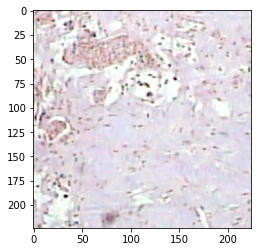

In [ ]:
m,b=next(iter(Data_generator(data_train,labels_train)))
print(m.shape)
print(b.shape)
plt.imshow(m[0])

In [ ]:
import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
optim = keras.optimizers.Adam(learning_rate =0.00008)
model.compile(optim, loss="binary_crossentropy", metrics=['accuracy'])

def step_decay(epoch):
     
     initAlpha = 0.00008
     factor = .6
     dropEvery = 25
     alpha = initAlpha * (factor ** np.floor((1 + epoch) / dropEvery))
     return float(alpha)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
batch_size =8
TrainSteps = len(data_train) // batch_size     
ValSteps   = len(data_test) // 1
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/breast-cancer-classification/40X/40x_desnet169.h5', save_best_only=True, verbose=2, monitor='val_accuracy',mode='max')
csv_logger = CSVLogger('/content/drive/MyDrive/breast-cancer-classification/40X/40x_desnet169.csv', append=True)


H = model.fit_generator(Data_generator(data_train,labels_train), epochs = 50 , steps_per_epoch=TrainSteps, validation_data =Data_generator(data_test,labels_test) ,
                validation_steps =ValSteps,
callbacks=[model_checkpoint, csv_logger , LearningRateScheduler(step_decay)],shuffle=True , class_weight=class_weight )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/50
199/199 [==============================] - ETA: 0s - loss: 0.4392 - accuracy: 0.7965
Epoch 1: val_accuracy improved from -inf to 0.76020, saving model to /content/drive/MyDrive/breast-cancer-classification/40X/40x_desnet169.h5
199/199 [==============================] - 59s 169ms/step - loss: 0.4392 - accuracy: 0.7965 - val_loss: 0.5033 - val_accuracy: 0.7602 - lr: 8.0000e-05
Epoch 2/50
199/199 [==============================] - ETA: 0s - loss: 0.2029 - accuracy: 0.9150
Epoch 2: val_accuracy improved from 0.76020 to 0.81888, saving model to /content/drive/MyDrive/breast-cancer-classification/40X/40x_desnet169.h5
199/199 [==============================] - 36s 163ms/step - loss: 0.2029 - accuracy: 0.9150 - val_loss: 0.5861 - val_accuracy: 0.8189 - lr: 8.0000e-05
Epoch 3/50
199/199 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9691
Epoch 3: val_accuracy improved from 0.81888 to 0.93367, saving model to /content/drive/MyDrive/breast-cancer-classification

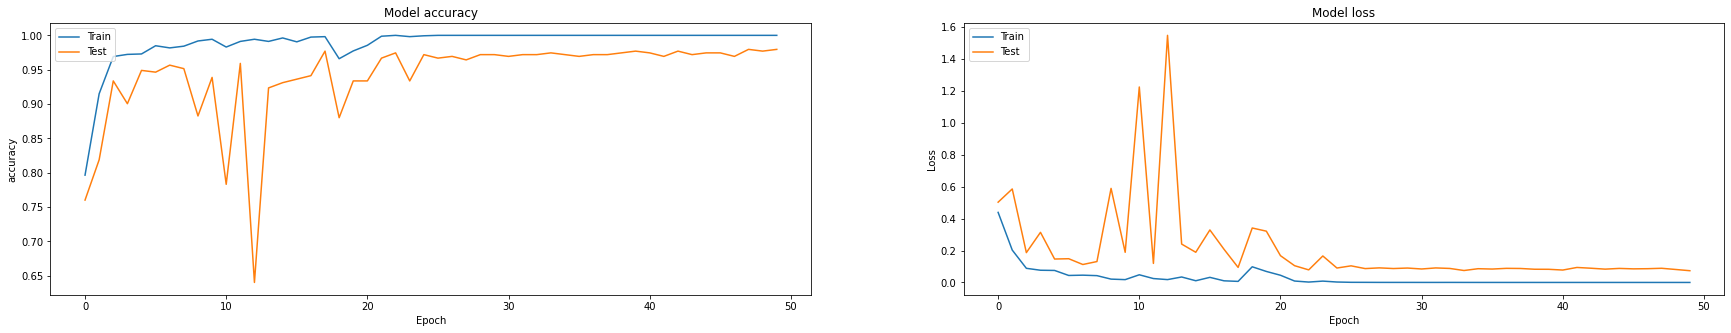

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
model=tf.keras.models.load_model('/content/drive/MyDrive/breast-cancer-classification/40X/40x_desnet169.h5')

In [ ]:
data_test = data_test/255
model.evaluate(data_test, labels_test)

13/13 [==============================] - 15s 241ms/step - loss: 0.0752 - accuracy: 0.9749


[0.07519366592168808, 0.9749373197555542]

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(data_test, batch_size=1)

[INFO] evaluating network...
399/399 [==============================] - 11s 20ms/step


In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)
testY = np.argmax(labels_test, axis=1)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("precision_score : ",precision_score(testY, predIdxs  ,  average='weighted' ))
print("Recall Score : ",recall_score(testY, predIdxs ,average='weighted'))
print("f1_score : ",f1_score(testY, predIdxs ,average='weighted'))

precision_score :  0.9753306304241363
Recall Score :  0.974937343358396
f1_score :  0.9750263323260062


In [ ]:
target_names = ['Benign ', 'Malignant']
print(classification_report(testY, predIdxs, target_names=target_names))

              precision    recall  f1-score   support

     Benign        0.95      0.98      0.96       134
   Malignant       0.99      0.97      0.98       265

    accuracy                           0.97       399
   macro avg       0.97      0.98      0.97       399
weighted avg       0.98      0.97      0.98       399



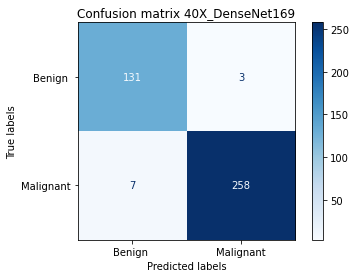

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm=confusion_matrix(testY,predIdxs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=target_names)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.title('Confusion matrix 40X_DenseNet169')
plt.ylabel("True labels")
plt.show()

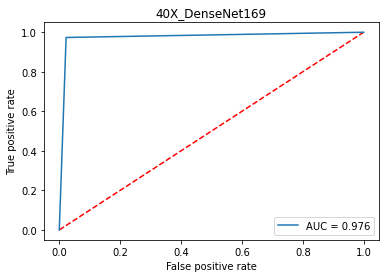

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(testY , predIdxs)
false_positive_rate, true_positive_rate, threshold = roc_curve( testY , predIdxs)
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('40X_DenseNet169')
plt.legend(loc='best')
plt.show()
plt.close()